In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gc
import matplotlib
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter

import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
torch.manual_seed(42)

In [2]:
train_review=pd.read_pickle('../input/valid-vectors-review/train_review')
test_review=pd.read_pickle('../input/valid-vectors-review/test_review')

In [3]:
#tokenize reviews and set the max of tokens to 150
def resize(x):
    max_len=150
    if len(x)>=max_len:
        return x[:max_len]
    return np.pad(x, (0,max_len-len(x)),constant_values="<pad>").tolist()

tokenizer=get_tokenizer('basic_english')
train_review["tokens"] = train_review.review.map(tokenizer).apply(resize)
test_review["tokens"] = test_review.review.map(tokenizer).apply(resize)

In [4]:
glove_vectors = torchtext.vocab.GloVe()
# fast_vectors = torchtext.vocab.FastText()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [03:51<00:00, 9493.14it/s] 


In [5]:
gc.collect()

42

In [6]:
special_tokens = ['<unk>'] #add this special word to the list of vocab and give it an index, usually 0
min_freq = 1
vocab=torchtext.vocab.build_vocab_from_iterator(train_review["tokens"], min_freq=min_freq, specials=special_tokens)
#set it as default, so every time i run vocab[word] 
# and this word doesn't exist in the vocab list, it will return the indice of the word "unk"
vocab.set_default_index(vocab['<unk>']) 
train_review["ids"] = train_review.tokens.map(vocab)
test_review["ids"] = test_review.tokens.map(vocab)

<br>
<br>
<br>

# Trainable/Static embeddings

In [7]:
#dataset
class custom_dataset(Dataset):
    def __init__(self,x,y=None):
        self.x=x
        self.y=y
         
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self,idx):
        if self.y is None:
            return self.x[idx]
        return self.x[idx], self.y[idx]
    

train_dataset = custom_dataset(torch.tensor(train_review.ids),torch.tensor(train_review.sentiment))
testset = custom_dataset(torch.tensor(test_review.ids))

dt_length=len(train_dataset)
trainset,valset = random_split(train_dataset, [int(dt_length*0.8), dt_length-int(dt_length*0.8)])

In [8]:
#model
class lstm_model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_index, n_layers, bidirectional, dropout_rate):
        super(lstm_model, self).__init__()
        
        #don't consider this index in training phase (pad_index) 
        # in = [batch_size=64,   seq_length= 200 word]
        # out = [batch_size=64,   seq_length= 200 word,   embed_dim=100]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=pad_index,
                                  _weight=None)
        
        # in = [batch_size=64,   seq_length= 200 word,   input_size=100] === one word[100 dim] is fed to the lstm
        # out = [batch_size=64,   seq_length= 200 word,   hidden_size=au choix], h,c=(n_layers, batch_size, hidden_size)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim ,num_layers=n_layers, bidirectional=bidirectional,
                            dropout= dropout_rate, batch_first=True)
        
        self.linear = nn.Linear(2*hidden_dim if bidirectional else hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()
                                        
    def forward(self,ids):
        
        embedded = self.embedding(ids)
        output, (hidden, cell) = self.lstm(embedded)
        if bidirectional:
            hidden = hidden[-2:].transpose(0,1).reshape(-1,2*hidden_dim)
        else:
            hidden = hidden[-1]
        ds = self.linear(hidden)
#         drop = self.dropout(ds)
        result = self.sigmoid(ds)
        
        return result

In [9]:
# Parameters
vocab_size = len(vocab)
embed_dim = 300
hidden_dim = 300
num_classes = 2
n_layers = 2
bidirectional = False
dropout_rate = 0.5
pad_index = vocab['<pad>']
lr = 5e-4
epochs=20
batch=8
#set trainable to True for trainable word embedding, and to false for using pretrained embeddings
trainable=False


#dataloader
train_loader = DataLoader(trainset, batch_size=batch, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch, shuffle=True)


model = lstm_model(vocab_size, embed_dim, hidden_dim, pad_index, n_layers, bidirectional, dropout_rate)
if not trainable:
    embeddings_weights = glove_vectors.get_vecs_by_tokens(vocab.get_itos())
    model.embedding.from_pretrained(embeddings_weights, freeze=True)
    
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

CrossEntropyLoss()

In [10]:
def get_accuracy(yp,yt):
    cm = (torch.argmax(yp, dim=1)==yt).sum()
    count=len(yp)
    return cm, count

def train_one_epoch():
    batches_loss=[]
    numer = 0
    denom = 0
    for batch_x, batch_y in train_loader:
        batch_x=batch_x.to(device)
        batch_y=batch_y.to(device)
        model.train()
        y_hat=model(batch_x)
        loss=loss_fn(y_hat, batch_y)
        cm, count=get_accuracy(y_hat,batch_y)
        numer+=cm
        denom+=count
        loss.backward()
        opt.step()
        opt.zero_grad()
        batches_loss.append(loss.item())
    return np.mean(batches_loss), (numer/denom).item()

@torch.no_grad()
def evaluate_one_epoch():
    batches_loss=[]
    numer = 0
    denom = 0
    for batch_x, batch_y in val_loader:
        batch_x=batch_x.to(device)
        batch_y=batch_y.to(device)
        model.eval()
        y_hat=model(batch_x)
        loss=loss_fn(y_hat, batch_y)
        batches_loss.append(loss.item())
        cm, count=get_accuracy(y_hat,batch_y)
        numer+=cm
        denom+=count
    return np.mean(batches_loss), (numer/denom).item()


def fit_model(epochs):
    print("Training...")
    train_accuracy = []
    train_losses = []
    val_accuracy = []
    val_losses = []
    for epoch in range(epochs):
        train_loss, tr_acc = train_one_epoch()
        train_losses.append(train_loss)
        train_accuracy.append(tr_acc)
        val_loss, val_acc = evaluate_one_epoch()
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        print(f"epoch {epoch+1}/{epochs}:  train loss: {train_loss: >6.4f},  train acc: {tr_acc: >6.4f} ================ val loss: {val_loss: >6.4f},  val acc: {val_acc: >6.4f}")
    return train_losses, val_losses, train_accuracy, val_accuracy


In [11]:
print(model)

lstm_model(
  (embedding): Embedding(44910, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


In [12]:
gc.collect()

63

In [13]:
train_losses, val_losses, train_accuracy, val_accuracy = fit_model(epochs)

Training...
epoch 1/20:  train loss: 0.6932,  train acc: 0.5051 ================ val loss: 0.6932,  val acc: 0.4902
epoch 2/20:  train loss: 0.6932,  train acc: 0.5020 ================ val loss: 0.6931,  val acc: 0.5170
epoch 3/20:  train loss: 0.6932,  train acc: 0.5015 ================ val loss: 0.6932,  val acc: 0.4902
epoch 4/20:  train loss: 0.6932,  train acc: 0.5033 ================ val loss: 0.6928,  val acc: 0.5098
epoch 5/20:  train loss: 0.6909,  train acc: 0.5342 ================ val loss: 0.6943,  val acc: 0.4978
epoch 6/20:  train loss: 0.6869,  train acc: 0.5278 ================ val loss: 0.6915,  val acc: 0.5316
epoch 7/20:  train loss: 0.6815,  train acc: 0.5490 ================ val loss: 0.6135,  val acc: 0.6888
epoch 8/20:  train loss: 0.5830,  train acc: 0.7221 ================ val loss: 0.5488,  val acc: 0.7572
epoch 9/20:  train loss: 0.5202,  train acc: 0.7853 ================ val loss: 0.5189,  val acc: 0.7824
epoch 10/20:  train loss: 0.4785,  train acc: 0.8268

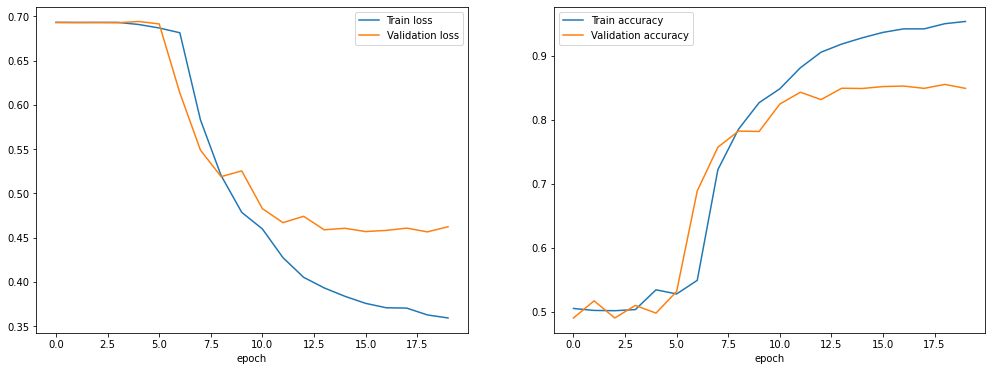

In [14]:
fig, ax=plt.subplots(1,2, figsize=(17,6))
ax[0].plot(range(epochs), train_losses, label="Train loss")
ax[0].plot(range(epochs), val_losses, label="Validation loss")
ax[0].set_xlabel("epoch")
ax[0].legend()
ax[1].plot(range(epochs), train_accuracy, label="Train accuracy")
ax[1].set_xlabel("epoch")
ax[1].plot(range(epochs), val_accuracy, label="Validation accuracy")
ax[1].legend()
plt.show()

# Test

In [15]:
test_loader = DataLoader(testset, batch_size=batch, shuffle=False)

In [16]:
pred=[]
with torch.no_grad():
    model.eval()
    for xbatch in test_loader:
        xbatch = xbatch.to(device)
        y_pred = model(xbatch)
        pred.append(y_pred)
        
pred = torch.row_stack(pred)

In [17]:
test_review["sentiment"]=torch.argmax(pred, dim=1).cpu()

In [18]:
# submission
# test_review[["id","sentiment"]].to_csv('submission.csv', index=False, header=True)